# Probabilistic Programming: Introduction to PyMC3

## Brief background
All the statistical methods that we have seen so far concentrated on probabilistic graphical models (also called [statistical models](https://en.wikipedia.org/wiki/Statistical_model)): random variables (RVs) that conditionally depend on each other through some probability distribution, or mathematical relation. Using Bayes theorem we could then write down algorithms to infer unobserved random variables in the graph. We either inferred the maximum likelihood (ML), maximum a posteriori (MAP), or the full or approximate posterior probability distribution.

The key ingredients we used were:

* Random variables (RVs): these may be conditionally dependent or independent as expressed by the graphical model that is used
* Probability distributions or densities (pdf): each RV's value is assumed to be a random sample from some distribution, which may depend on other RVs.
* The unnormalized likelihood of the graphical model given some observed values on a subset of RVs.

Combining all of these ingredients together with Bayes theorem gives us the unnormalized posterior probability density:

$$
P\left(\vec{x}\mid y\right) \propto P\left(y\mid \vec{x}\right) P\left(\vec{x}\right)
$$

Usually, it's impossible to compute normalization constant:
$$
\int d\vec{x} P\left(y\mid \vec{x}\right)
$$
This means that it is usually impossible to compute the true posterior probability distribution $P\left(\vec{x}\mid y\right)$ analytically. That is why we resort to maximum likelihood, MAP or approximations like Laplace (used with Gaussian Process Classifiers, GPC) or variational inference (used with the Gaussian Mixture Models, GMM).

## Probabilistic Programming Languages (PPL)

PPL aim to __provide the thee key ingredients listed above__ as ready to use building blocks, that can be used to __easily express any form of probabilistic graphical model__. The PPL then exploits the conditional dependence structures of the graphical model, computes the unnormalized likelihoods and exposes ready to use methods for doing point estimates (ML, MAP), approximate posteriors (Variational Inference) or __draw samples from the true posterior probability distribution__ (usually done through Markov Chain Monte Carlo MCMC).

Some notable PPL:
* [PyMC](https://docs.pymc.io/)
* [Stan](https://mc-stan.org/)
* [Edward](https://www.tensorflow.org/probability/api_docs/python/tfp/edward2)
* [Pyro](http://pyro.ai/)

We will focus on [PyMC3](https://github.com/pymc-devs/pymc3) which is the current stable release, which uses [theano](http://deeplearning.net/software/theano/) as the computational backend, but the [next version](https://github.com/pymc-devs/pymc4) will be built on top of [tensorflow2](https://www.tensorflow.org/alpha/guide/effective_tf2).

---

### Installation
__Windows__ users are recommended to install pymc3's requirements using `conda` as follows

```
conda install numpy scipy mkl-service libpython m2w64-toolchain
conda install theano pygpu
```
Users of other operating systems can disregard the `m2w64-toolchain` requirement, as unix usually comes with c compilers.

Then you can install pymc3 __via conda-forge__:
```
conda install -c conda-forge pymc3
```
__Via pypi__:
```
pip install pymc3
```
__Latest (unstable)__:
```
pip install git+https://github.com/pymc-devs/pymc3
```

---

## General API

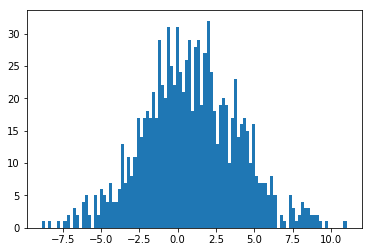

In [37]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import seaborn as sns
from matplotlib import pyplot as plt

# We will first draw some normally distributed observations
# to predict later on

MU = 0.87
SIGMA = 3.14
OBS = np.random.normal(loc=MU, scale=SIGMA, size=1000)

plt.hist(OBS, 100);

## 1. Model creation

Models in PyMC3 are centered around the `Model` class. It has references to all random variables (RVs) and computes the model `logp` and its gradients. Usually, you would instantiate it as part of a `with` context:

In [38]:
with pm.Model() as model:
    # Model definition
    pass
print(type(model))
model

<class 'pymc3.model.Model'>


We discuss RVs further below but let’s create a simple model to explore the `Model` class.

In [39]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sigma = pm.Gamma('sigma', alpha=1, beta=1)
    observed = pm.Normal('obs', mu=mu, sigma=sigma,
                         observed=OBS)

# We can view the basic RVs
print('Basic RVs', model.basic_RVs)

# We can view the free RVs that are used for MCMC
print('Free RVs', model.free_RVs)

# We can view the observed RVs
print('Observed RVs', model.observed_RVs)

# We can view the deterministic RVs (nodes in the graph that are determined by others)
print('Deterministics', model.deterministics)

# We can also compute the unnormalized log posterior probability
point = model.test_point
point['mu'] = 0
point['sigma'] = 1
model.logp(point)

Basic RVs [mu, sigma_log__, obs]
Free RVs [mu, sigma_log__]
Observed RVs [obs]
Deterministics [sigma]


array(-6126.34219831)

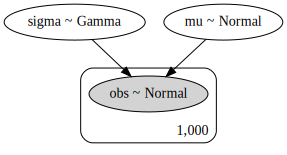

In [40]:
# We can view the probabilistic graphical model
pm.model_to_graphviz(model)

## 2. Probability Distributions

PyMC3 comes with several [built-in probability distributions](https://docs.pymc.io/api/distributions.html) that can be used to create models

In [41]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(m

In [42]:
help(pm.NormalMixture)

Help on class NormalMixture in module pymc3.distributions.mixture:

class NormalMixture(Mixture)
 |  Normal mixture log-likelihood
 |  
 |  .. math::
 |  
 |      f(x \mid w, \mu, \sigma^2) = \sum_{i = 1}^n w_i N(x \mid \mu_i, \sigma^2_i)
 |  
 |  ========  =======================================
 |  Support   :math:`x \in \mathbb{R}`
 |  Mean      :math:`\sum_{i = 1}^n w_i \mu_i`
 |  Variance  :math:`\sum_{i = 1}^n w_i^2 \sigma^2_i`
 |  ========  =======================================
 |  
 |  Parameters
 |  ----------
 |  w : array of floats
 |      w >= 0 and w <= 1
 |      the mixture weights
 |  mu : array of floats
 |      the component means
 |  sigma : array of floats
 |      the component standard deviations
 |  tau : array of floats
 |      the component precisions
 |  comp_shape : shape of the Normal component
 |      notice that it should be different than the shape
 |      of the mixture distribution, with one axis being
 |      the number of components.
 |  
 |  Note: Yo

In [43]:
# Each free random variable has its logp
print(mu.logp(point))
print(model['sigma_log__'].logp(point))

-0.9189385332046727
-1.0


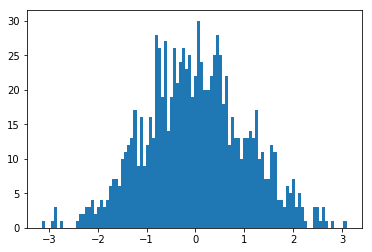

In [44]:
# Each random variable has its random method to draw samples from it conditional on its parents
plt.hist(mu.random(size=1000), 100);

{'sigma': (1000,), 'obs': (1000, 1000), 'mu': (1000,), 'sigma_log__': (1000,)}


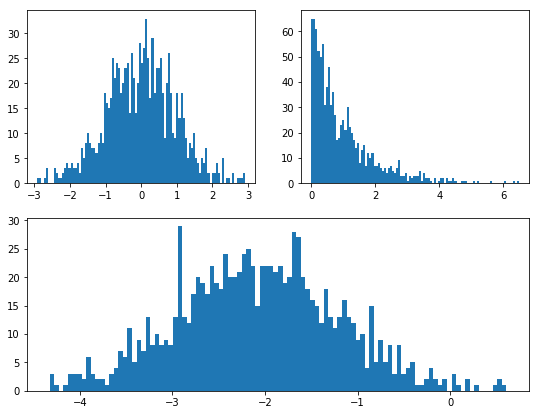

In [45]:
# Models can be used to generate forward samples (sample_prior_predictive)
with model:
    prior = pm.sample_prior_predictive(1000)
print({k: v.shape for k, v in prior.items()})

plt.figure(figsize=(9, 7))
plt.subplot(221)
plt.hist(prior['mu'], 100)
plt.subplot(222)
plt.hist(prior['sigma'], 100)
plt.subplot(212)
plt.hist(prior['obs'][:, 0], 100);

## 3. Inference
Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC3 supports two broad classes of inference: sampling and variational inference.

### 3.1 Sampling

The main entry point to MCMC sampling algorithms is via the `pm.sample()` function. By default, this function tries to auto-assign the right sampler(s) and auto-initialize if you don’t pass anything.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3971.31draws/s]
The acceptance probability does not match the target. It is 0.8900029693376501, but should be close to 0.8. Try to increase the number of tuning steps.
/home/lpaz/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/home/lpaz/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_

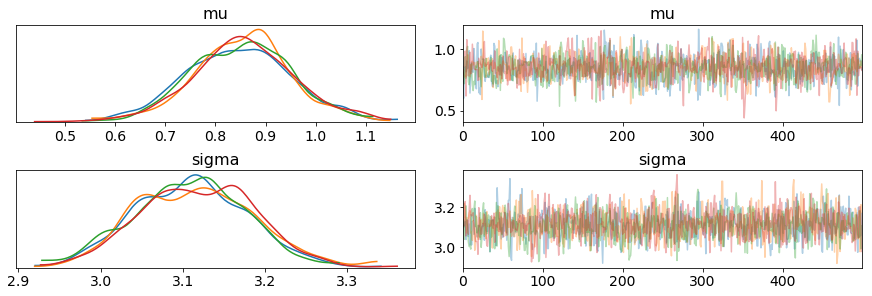

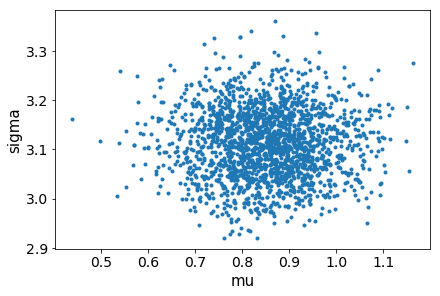

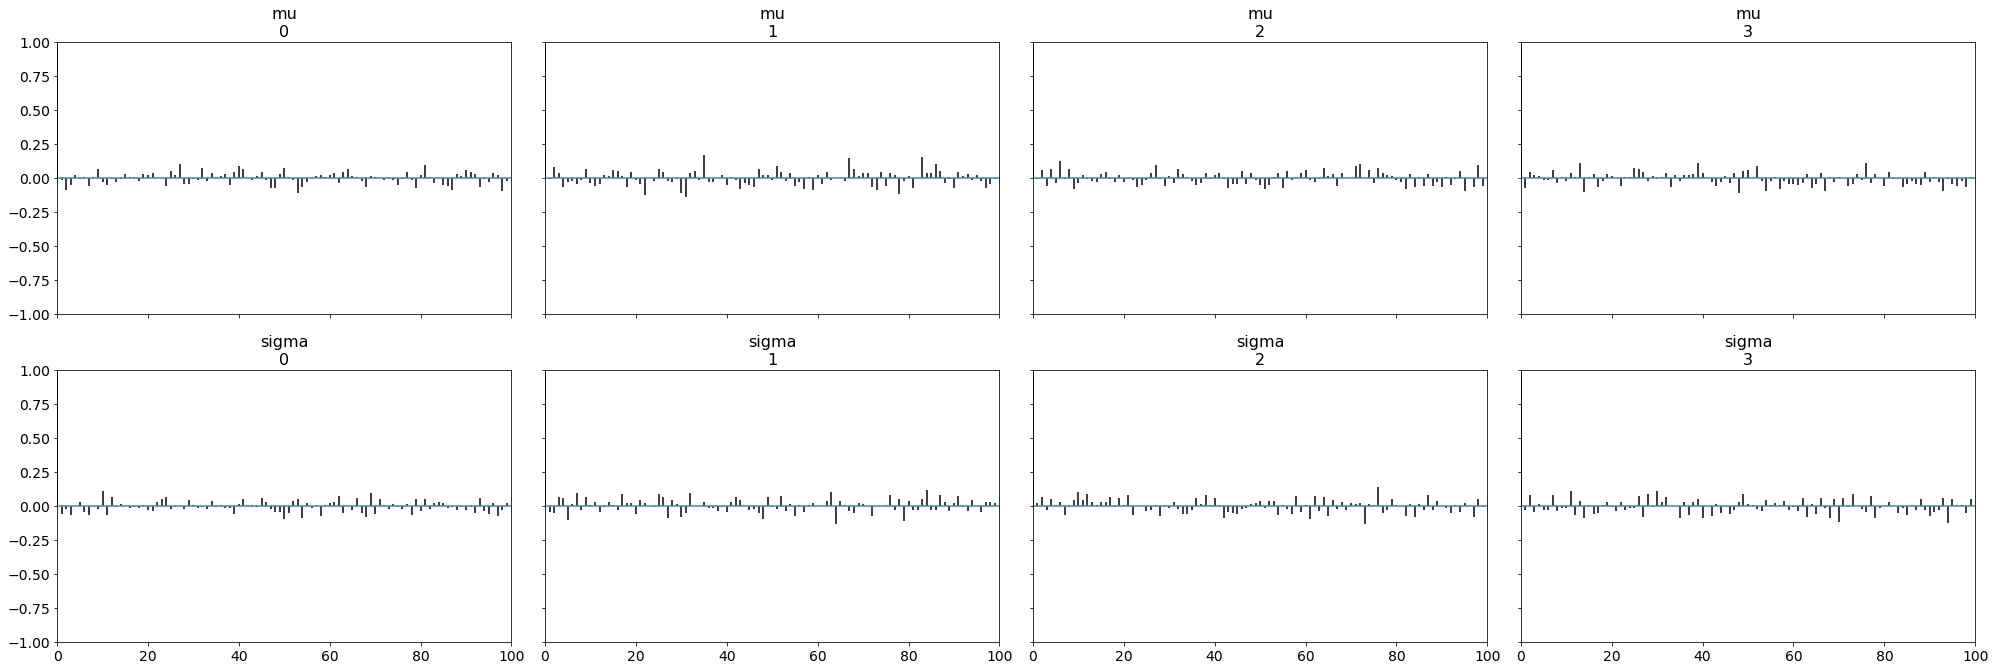

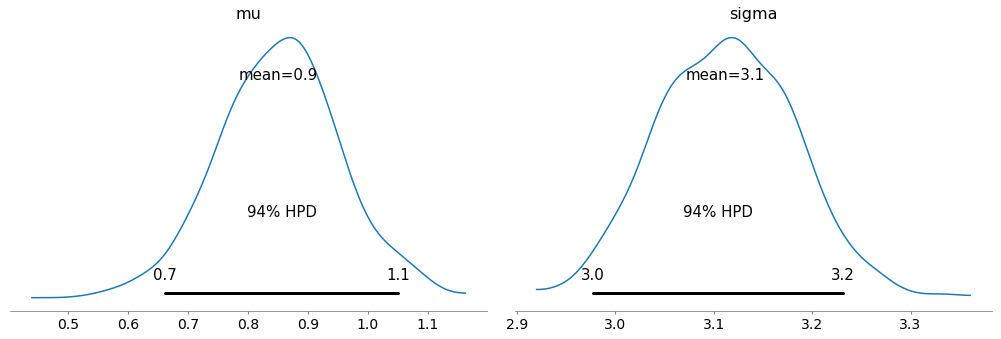

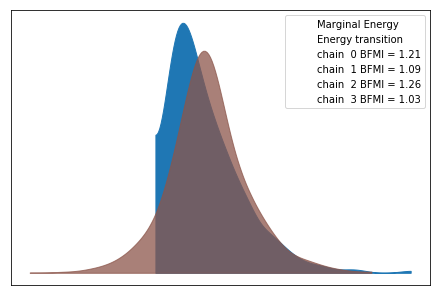

In [46]:
with model:
    trace = pm.sample()
    pm.traceplot(trace)
    pm.pairplot(trace)
    pm.plot_autocorr(trace)
    pm.plot_posterior(trace)
    pm.energyplot(trace)

### 3.2 Variational inference
PyMC3 supports various Variational Inference techniques. While these methods are much faster, they are often also less accurate and can lead to biased inference. The main entry point is `pymc3.fit()`

In [47]:
with model:
    approx = pm.fit()
print(approx)

Average Loss = 2,588.2: 100%|██████████| 10000/10000 [00:04<00:00, 2201.02it/s]
Finished [100%]: Average Loss = 2,588.1


Approximation{MeanFieldGroup[2]}


/home/lpaz/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


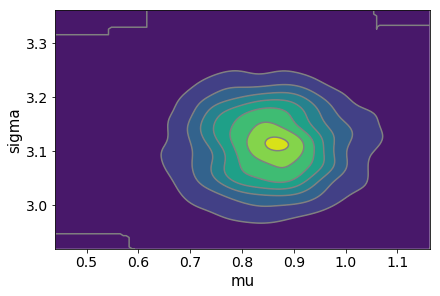

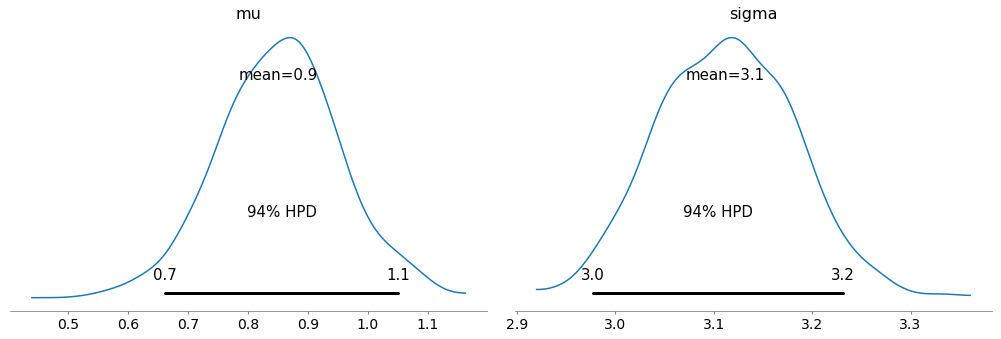

In [48]:
approx_samples = approx.sample(2000)
with model:
    pm.pairplot(trace, kind='kde')
    pm.plot_posterior(trace)

## 4. Posterior predictive sampling

The `sample_posterior_predictive()` function performs prediction on hold-out data and posterior predictive checks.

In [49]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

100%|██████████| 2000/2000 [00:00<00:00, 2360.99it/s]


In [50]:
ppc['obs'].shape

(2000, 1000)

/home/lpaz/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


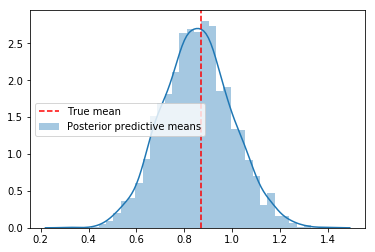

In [51]:
plt.figure()
ax = sns.distplot(ppc['obs'].mean(axis=1), label='Posterior predictive means')
ax.axvline(MU, color='r', ls='--', label='True mean')
ax.legend();

## 5. Point estimate
We can also compute the MAP through optimization using the `fit_MAP` function

In [52]:
with model:
    MAP = pm.find_MAP()
MAP

/home/lpaz/repos/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2,558.3, ||grad|| = 0.013718: 100%|██████████| 13/13 [00:00<00:00, 1397.38it/s]  


{'mu': array(0.84737338),
 'sigma': array(3.10630077),
 'sigma_log__': array(1.13343256)}

---

#### Sampling from a distribution

Conceptually, given a certain [statistical model](https://en.wikipedia.org/wiki/Statistical_model) (sometimes also referred to as the observed data's generative process) there are three different sampling schemes:
1. Given the assumptions from the data generation process, we can draw samples from it. This is referred to as `sample_prior_predictive` in PyMC3.
2. Lets assume we observed some values that came from the data generation process. We now want to infer the posterior probability distribution of the unobserved random variates given the observed data. To do this, we exploit Bayes Theorem. However, there are models in which it is impossible to compute an analytical form for the posterior, so we must rely on approximate methods. PyMC3 builds heavily on MCMC, where the analytical posterior is not computed, but samples of the unobserved random variates are drawn from it. This procedure is handled by the `sample` function.
3. Given some posterior distribution over unobserved variables, we now want to predict what will be some likely values that we could observe in the future. We do so by sampling from the data generation process, conditioned on the posterior distribution over the unobserved variables. This is called `sample_posterior_predictive`.

In practice, one must first define the statistical model which we assume underlies the data generation process. This is done with the `Model` context manager. After defining the model, one can use any of the three sampling schemes listed above.

---

To illustrate how one defines a model in PyMC3 we use a mixture of two gaussians. We parametrize the model as follows in mathematical notation:

$$
c_{i} \sim Categorical(\alpha, 1-\alpha)
$$
$$
x_{i} \sim N(\mu_{c_{i}}, \tau_{c_{i}})
$$

$c_{i}$ is the category to which the observation belongs to. This category controls the gaussian's mean $\mu_{c_{i}}$ and precision $\tau_{c_{i}}$ (inverse of variance). Lets assume that:
$$
\alpha = 0.8
$$
$$
\mu = [0, 3]
$$
$$
\tau = [1, 1]
$$

One of the development goals of PyMC3 was to make writting down the model as similar as possible to writting down the mathematical relations between the random variables. This involves some symbolic math handling, and PyMC3 relies on [`theano`](http://deeplearning.net/software/theano/) to do so (note that `theano` support has been discontinued and the future PyMC4 version will be written on top of [`tensorflow`](https://www.tensorflow.org/)).

In [3]:
#build a pymc model: this is a mixture of Gaussians.
#This is the model we will sample from

# We start by defining the constant hyper parameters
# (we could do this inside the model context too)
alpha = 0.6
# We wrap sigmas and centers as tensor variables to be able to
# use advanced indexing with symbolic expressions
sigmas = tt.as_tensor_variable([1, 1])
centers = tt.as_tensor_variable([0, 3])

# Now we enter the model context. All random variables within the context
# are assumed to belong to the model, and will be added to the
# bayes graph
with pm.Model() as model:
    # We define the c categorical random variable
    category = pm.Categorical("category", [alpha, 1 - alpha])
    # The category RV is a theano tensor and we can do symbolic math with it
    
    mu = pm.Deterministic('mu', centers[category])
    sigma = pm.Deterministic('sigma', sigmas[category])
    # Just to illustrate the symbolic math capabilities, we pass tau to
    # the Normal, instead of just the sigma
    mixture = pm.Normal('mixture', mu=mu, tau=1/sigma**2)

The `model` object defines the statistical model and holds all the random variates. This simple model has only two types of RVs in it which are:
1. free_RVs: Random variables that are used during the MCMC sampling. In our case these RVs are the `category` and `mixture` random variables.
2. deterministics: Mathematical relations of other variables that we want to track during the MCMC run (we flag that we want to track them with the `pm.Deterministic` function) but they don't contribute explicitly to the posterior probability density. In our case these RVs are `mu` and `sigma`. More details on this later.

In [4]:
# The model instance has refences to all RVs
print(model.free_RVs)
print(model.deterministics)
print(model.basic_RVs)

[category, mixture]
[mu, sigma]
[category, mixture]


In [5]:
# We can access the RVs in the model as attributes or dictionary keys
print(model.mixture)
print(model['mixture'] == model.mixture)

mixture
True


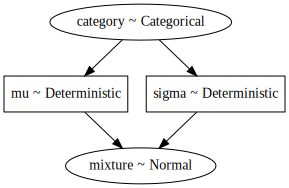

In [6]:
# We can plot the Bayes DAG if we have graphviz installed
pm.model_to_graphviz(model)

Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [category]
>NUTS: [mixture]
100%|██████████| 4500/4500 [00:02<00:00, 1662.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/lpaz/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


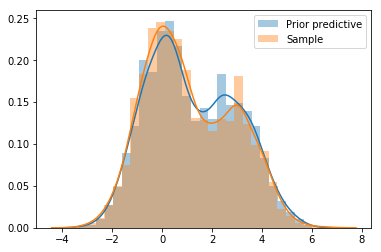

In [7]:
with model:
    prior = pm.sample_prior_predictive(4000)
    # As we don't have any observed data, pm.sample
    # should give the same distribution as the prior
    # This is not safe in general
    trace = pm.sample(4000, cores=1, chains=1)
sns.distplot(prior['mixture'], hist_kws={'alpha': 0.4}, label='Prior predictive')
sns.distplot(trace['mixture'], hist_kws={'alpha': 0.4}, label='Sample')
plt.legend()

The distribution plots don't match nicely because `sample` uses the MCMC procedure whereas `sample_prior_predictive` uses the model's distributions random number generators directly to get what are called forward samples. This procedure is faster and more accurate to generate samples from a given distribution, but does not work well to get samples conditioned on some observed values, which is the entire point of bayesian inference.

So now we turn onto the key question, **how do we sample conditioned on some observations?**

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [category]
>NUTS: [alpha]
Sampling 4 chains: 100%|██████████| 84000/84000 [00:43<00:00, 1931.03draws/s]


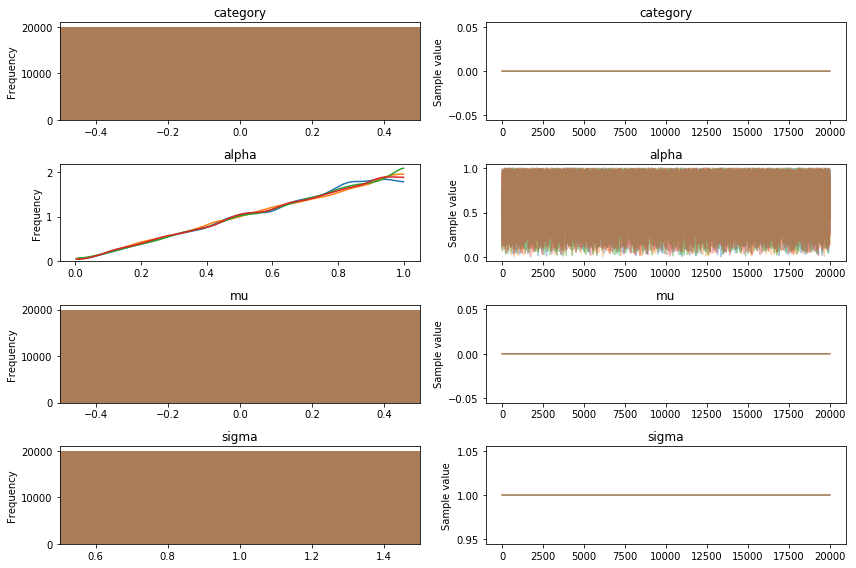

In [9]:
# The observations must be included when the model is defined
# So we have to repeat the model definition. This could be made
# easier with a model factory function.

# We wrap sigmas and centers as tensor variables to be able to
# use advanced indexing with symbolic expressions
sigmas = tt.as_tensor_variable([1, 1])
centers = tt.as_tensor_variable([0, 3])

# Here we set the observed data, we can set it as a numpy.array
# or a pandas.Series. We will rely on the data that we generated with
# the sample_prior_predictive
observed_data = prior['mixture']

# Now we enter the model context. All random variables within the context
# are assumed to belong to the model, and will be added to the
# bayes graph
with pm.Model() as inference_model:
    # To make things more interesting, we define alpha as an RV
    alpha = pm.Beta('alpha', 1, 1)
    # We define the c categorical random variable
    category = pm.Categorical("category", tt.as_tensor_variable([alpha, 1 - alpha]))
    # The category RV is a theano tensor and we can do symbolic math with it
    
    mu = pm.Deterministic('mu', centers[category])
    sigma = pm.Deterministic('sigma', sigmas[category])
    # Just to illustrate the symbolic math capabilities, we pass tau to
    # the Normal, instead of just the sigma
    mixture = pm.Normal('mixture', mu=mu, tau=1/sigma**2,
                        observed=observed_data) # Here we say that we observed this RV

    # In order to perform inference we call pm.sample
    step = pm.CategoricalGibbsMetropolis([category])
    trace = pm.sample(20000, tune=1000, chains=4, cores=4, step=step)
    # We can visualize the markov chains with traceplot
    pm.traceplot(trace)

##### Sampling from a model
The hard part is building the model. The sampling is easy: one defines a MCMC object, samples it, and the plots the trace of the variables of interest (note how each variable has a name to identify it).

In [3]:
#MCMC sampling
M = MCMC(model)
M.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.9 sec

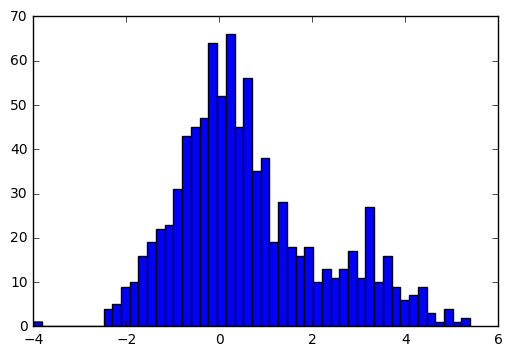

In [4]:
#plot(M)
hist(M.trace('mixture')[:],bins=50)
show()


#### Bayesian inference and user defined stochastic variables
Here we want to do Bayesian inference for a Bernoulli r.v. with parameter p. 
We will define a prior for p, in this case a uniform Beta, then build a user defined model for the Bernoulli variable.

The user defined process uses a `@stochastic` decorator, in this case flagging `observed = True`, which assumes the output of this process is observed. One defines two subfunctions, one computing the log-likelihood and the second to sample from it. Note how the value passed to `my_process` is the vector of the observed values, and we need to compute the log-likelihood of the whole vector in `logp`. 

In [7]:
#sets us an uniform prior
a = 1
b = 1
beta = Beta('parameter',a,b)

#generates observations
N_obs = 1000
p_true = 0.67
observed_values = choice(2, N_obs, p=[1-p_true,p_true])

@stochastic(observed = True, dtype = np.int)
def my_process(value = observed_values, prob = beta):
    """An example of a user defined stochastic process."""

    def logp(value,prob):
        if prob > 1 or prob < 0:
            return -np.inf
        else:
            return np.sum(value*np.log(prob) + (1-value)* np.log(1-prob))

    def random(prob):
        return choice(2, 1, p=[1-prob,prob])
    

##### Posterior approximation or MAP
Once the model is defined, we can sample from the posterior of the parameter, given the observations, or do Maximum a posteriori inference. 

In [9]:
model_inference = Model([my_process,beta])
M = MCMC(model_inference)
M.sample(iter=10000, burn=1000, thin=10)
hist(M.trace('parameter')[:],bins=50)
show()


In [31]:
Mp = MAP(model_inference)
Mp.fit()
p_opt =  Mp.get_node('parameter').get_value()
BIC = Mp.BIC
print("optimal value of parameter is",p_opt,"BIC is",BIC)


optimal value of parameter is 0.6720000004079242 BIC is 1272.41417648


### Exercise
Consider the DTMC of the simple flu model, and assume the probability of infection is a parameter p. 
Fix a value of this p and generate 100 or 1000 samples from the process, storing the state after N steps (say N=1000) so that the dtmc is likely to have reached steady state. 

Build a pyMC model, following the previous example, where the used defined model computes the likelihood by first computing the transient probability after N steps of the DTMC for a given p  (the DTMC can also be passed as a parent to the function `my_process`), and then computes the likelihood of the observations. 

Place a beta prior (e.g. uniform) on the probability p of infection, and do MAP and MCMC inference.



